# Book cover: regression maps with Nino 3.4

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from scipy import signal

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## 0. Regression function (no intercept)

In [2]:
def regress_time_series_maps(time_series, maps):
    return (time_series * maps).sum('T', skipna = False) / (time_series ** 2).sum('T')

## 1. DJF Nino 3.4 from ERSST v5 1980-2019

40 years (Dec 1979 - Feb 1980) - (Dec 2019 - Feb 2020)

In [3]:
T_str = 'T/(Dec%201979)/(Feb%202020)/RANGEEDGES/T/3/runningAverage/T/(Dec-Feb)/VALUES/'
time_fix = 'T/(days%20since%201960-01-01)streamgridunitconvert/'

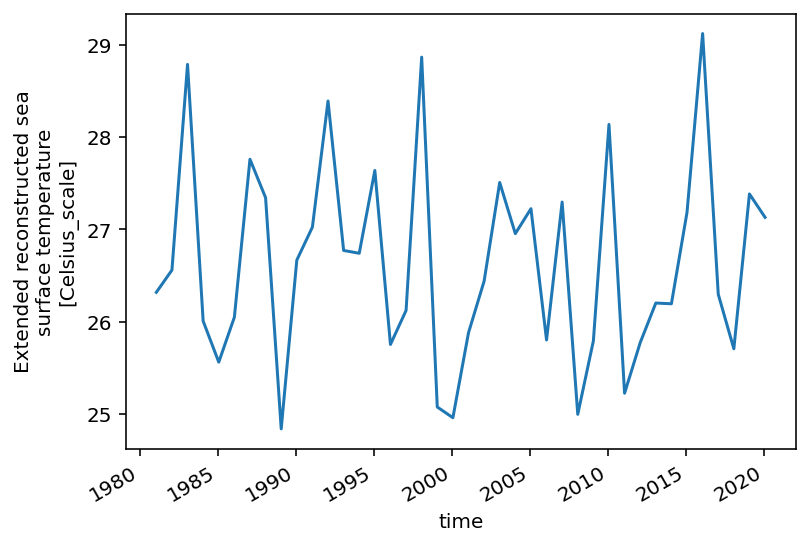

In [4]:
ERSSTv5_loc = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/zlev/removeGRID/'
n34_range = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/'
n34_url = ERSSTv5_loc + n34_range + T_str + time_fix + 'dods'
n34_ds = xr.open_dataset(n34_url)
n34_ds.sst.plot();

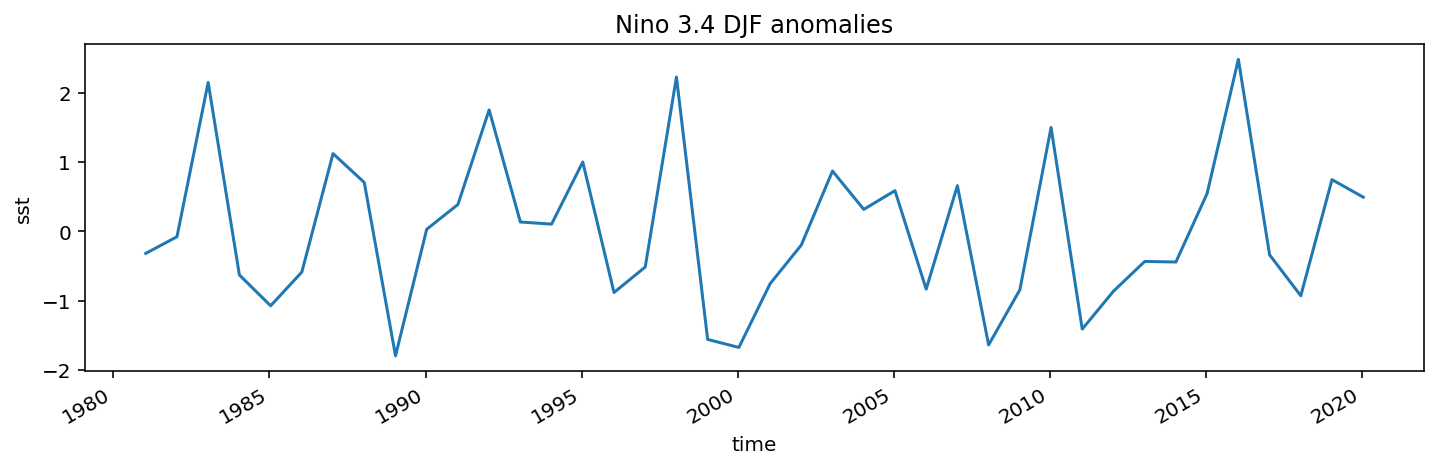

In [5]:
n34 = n34_ds.sst
n34a = n34 - n34.mean('T')
fig, ax = plt.subplots(figsize = (12, 3))
n34a.plot()
plt.title('Nino 3.4 DJF anomalies');

## 2. Global SST

In [6]:
# Construct the url pointing to the data
dl_loc   = 'SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/'
sst_url  = 'https://iridl.ldeo.columbia.edu/' + dl_loc + T_str + 'zlev/removeGRID/' + time_fix + 'dods'
sst_url

'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/(Dec%201979)/(Feb%202020)/RANGEEDGES/T/3/runningAverage/T/(Dec-Feb)/VALUES/zlev/removeGRID/T/(days%20since%201960-01-01)streamgridunitconvert/dods'

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


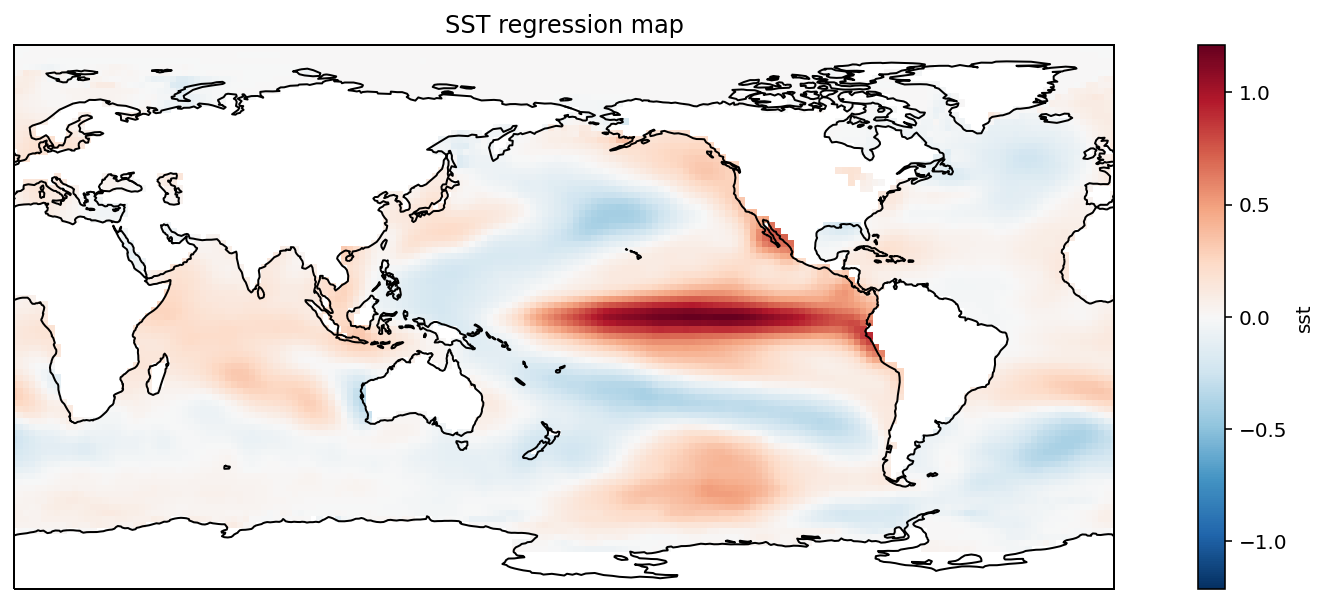

In [7]:
sst_ds = xr.open_dataset(sst_url)
sst = sst_ds.sst
# Anomalies with respect to the full period
ssta = sst - sst.mean('T')
sst_map = regress_time_series_maps(n34a, ssta)

proj_map = ccrs.PlateCarree(central_longitude = 180)
proj_dta = ccrs.PlateCarree()

fig = plt.figure(figsize = (15, 5))
ax = plt.subplot(projection = proj_map)

sst_map.plot(ax = ax, transform = proj_dta)
ax.coastlines()
ax.set_title('SST regression map');

## 3. Global 2m temperature

In [8]:
# Construct the url pointing to the data
dl_loc   = 'SOURCES/.NOAA/.NCEP/.CPC/.GHCN_CAMS/.gridded/.deg0p5/.temp/'
t2m_url  = 'https://iridl.ldeo.columbia.edu/' + dl_loc + T_str + time_fix + 'dods'
t2m_url

'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.GHCN_CAMS/.gridded/.deg0p5/.temp/T/(Dec%201979)/(Feb%202020)/RANGEEDGES/T/3/runningAverage/T/(Dec-Feb)/VALUES/T/(days%20since%201960-01-01)streamgridunitconvert/dods'

In [9]:
t2m_ds = xr.open_dataset(t2m_url)
t2m = t2m_ds.temp
# Anomalies with respect to the full period
t2ma = t2m - t2m.mean('T')

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
# detrend
nt = len(n34a)
time = n34a.copy(data = np.arange(0, nt))
time = time - time.mean('T')
trend_map = regress_time_series_maps(time, t2ma)
t2ma_detrended = t2ma - time * trend_map

In [11]:
# check detrend using signal.detrend
t2ma2D = t2ma.stack(YX=('Y', 'X'))
goodXY = ~np.isnan(t2ma2D.sum('T', skipna = False))
dta = t2ma2D.values[:,goodXY]

#signal.detrend does not like nan so go to numpy land
dta_detrended = signal.detrend(dta, axis = 0)

nt = t2m_ds.T.size
nx = t2m_ds.X.size
ny = t2m_ds.Y.size

t2ma_detrended_check2D = np.full((nt, ny * nx), np.nan)
t2ma_detrended_check2D[:, goodXY] = dta_detrended
t2ma_detrended_check = t2ma.copy(data = t2ma_detrended_check2D.reshape(nt, ny, nx))

np.abs(t2ma_detrended_check - t2ma_detrended).max().values

array(1.35061218e-05)

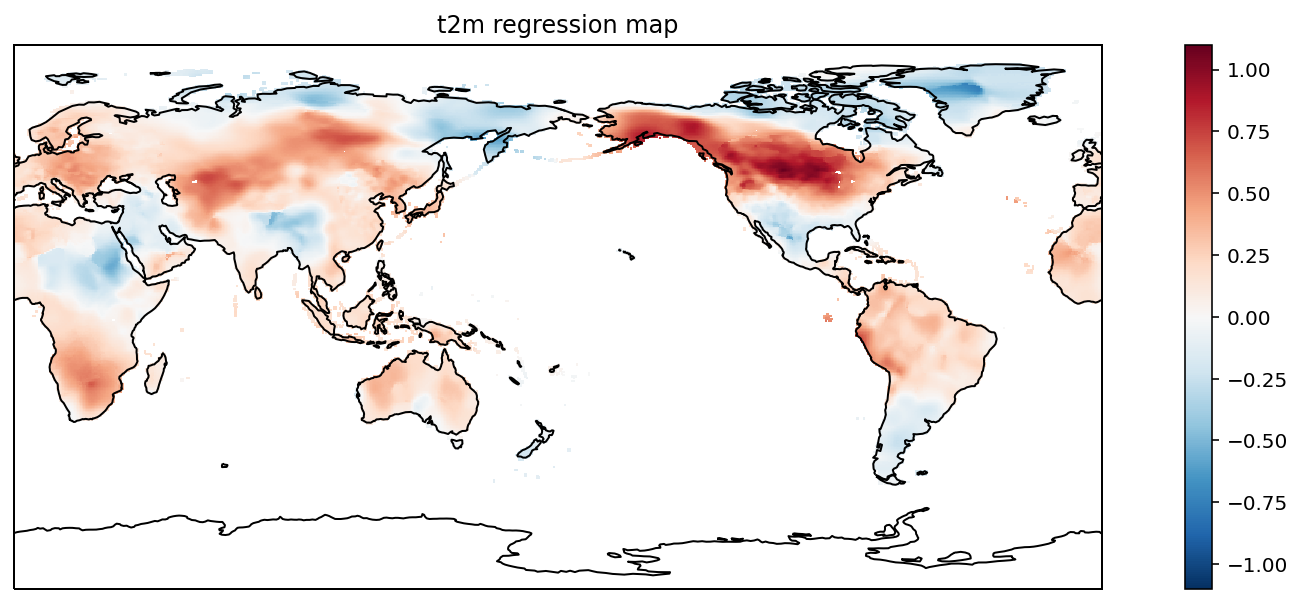

In [12]:
t2m_map = regress_time_series_maps(n34a, t2ma_detrended)

fig = plt.figure(figsize = (15, 5))
ax = plt.subplot(projection = proj_map)

t2m_map.plot(ax = ax, transform = proj_dta)
ax.coastlines()
ax.set_title('t2m regression map');

## 4. Global precipitation

In [13]:
# Construct the url pointing to the data
dl_loc = 'SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/a%3A/.RETRO/.rain/T/0.0/monthlyAverage/T/(Jan%201979)/551.5/RANGE/%3Aa%3A/.REALTIME/.rain/T/0.0/monthlyAverage/%3Aa/appendstream/'
prcp_url  = 'https://iridl.ldeo.columbia.edu/' + dl_loc + T_str + time_fix + 'dods'
prcp_url

'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/a%3A/.RETRO/.rain/T/0.0/monthlyAverage/T/(Jan%201979)/551.5/RANGE/%3Aa%3A/.REALTIME/.rain/T/0.0/monthlyAverage/%3Aa/appendstream/T/(Dec%201979)/(Feb%202020)/RANGEEDGES/T/3/runningAverage/T/(Dec-Feb)/VALUES/T/(days%20since%201960-01-01)streamgridunitconvert/dods'

In [14]:
prcp_ds = xr.open_dataset(prcp_url)
prcp_ds

<xarray.Dataset>
Dimensions:  (T: 40, X: 720, Y: 360)
Coordinates:
  * Y        (Y) float32 -89.75 -89.25 -88.75 -88.25 ... 88.25 88.75 89.25 89.75
  * X        (X) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75
  * T        (T) datetime64[ns] 1981-01-14T12:00:00 ... 2020-01-15
Data variables:
    rain     (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


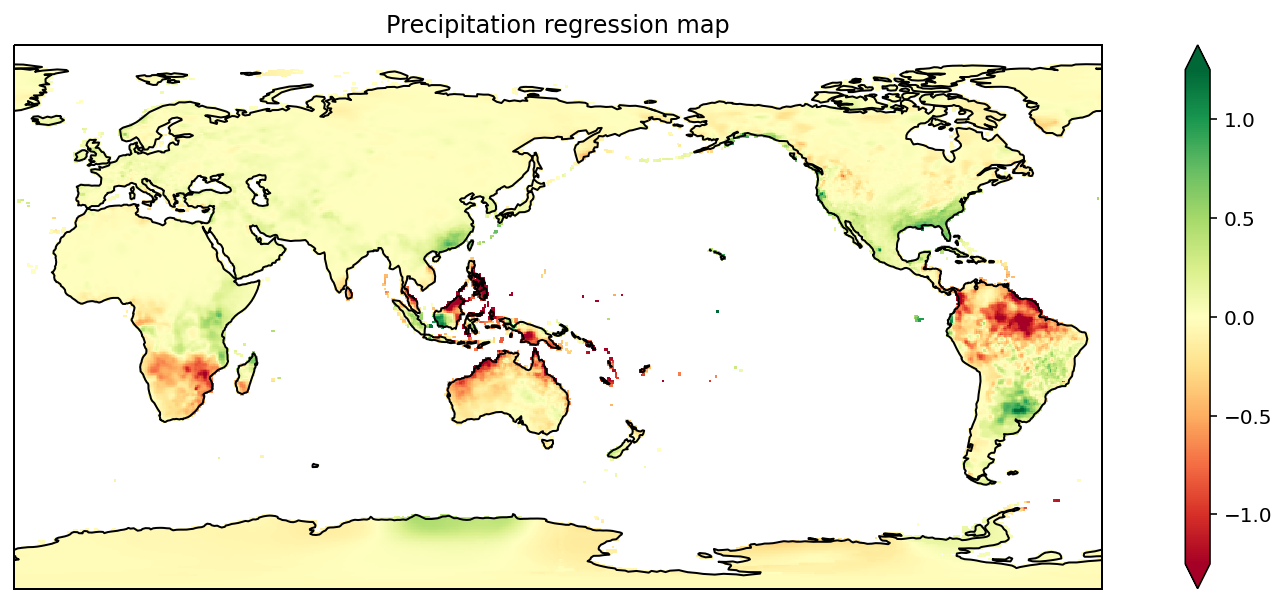

In [15]:
# Anomalies with respect to the full period
prcpa = prcp_ds.rain - prcp_ds.rain.mean('T')
prcp_map = regress_time_series_maps(n34a, prcpa)

proj_map = ccrs.PlateCarree(central_longitude = 150)
proj_dta = ccrs.PlateCarree()

fig = plt.figure(figsize = (15, 5))
ax = plt.subplot(projection = proj_map)

prcp_map.plot(ax = ax, vmin = -1.25, cmap = 'RdYlGn', transform = proj_dta)
ax.coastlines()
ax.set_title('Precipitation regression map');

## 5. 500 hPa height

In [16]:
# Construct the url pointing to the data
dl_loc   = 'SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Intrinsic/.PressureLevel/.phi/P/500/VALUE/P/removeGRID/'
phi_url  = 'https://iridl.ldeo.columbia.edu/' + dl_loc + T_str + time_fix + 'dods'
phi_url

'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Intrinsic/.PressureLevel/.phi/P/500/VALUE/P/removeGRID/T/(Dec%201979)/(Feb%202020)/RANGEEDGES/T/3/runningAverage/T/(Dec-Feb)/VALUES/T/(days%20since%201960-01-01)streamgridunitconvert/dods'

In [17]:
phi_ds = xr.open_dataset(phi_url)
phi_ds

<xarray.Dataset>
Dimensions:  (T: 40, X: 144, Y: 73)
Coordinates:
  * Y        (Y) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * X        (X) float32 0.0 2.5 5.0 7.5 10.0 ... 347.5 350.0 352.5 355.0 357.5
  * T        (T) datetime64[ns] 1981-01-14T12:00:00 ... 2020-01-15
Data variables:
    phi      (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

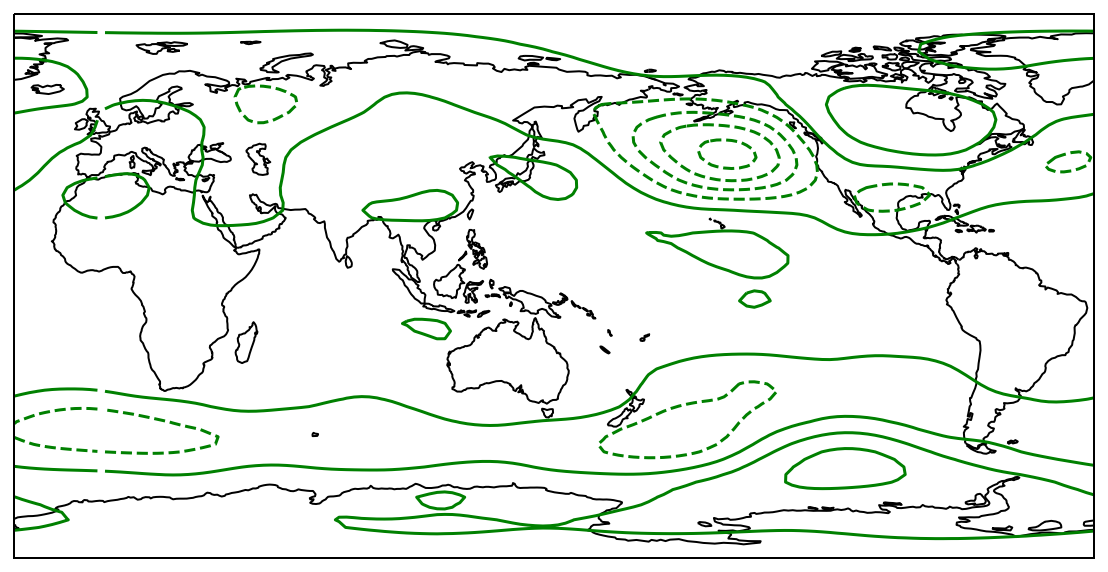

In [18]:
phi = phi_ds.phi
# Anomalies with respect to the full period
phia = phi - phi.mean('T')

phi_map = regress_time_series_maps(n34a, phia)

proj_map = ccrs.PlateCarree(central_longitude = 150)
proj_dta = ccrs.PlateCarree()

fig = plt.figure(figsize = (15, 5))
ax = plt.subplot(projection = proj_map)

phi_map.plot.contour(ax = ax, levels = 12, colors = 'g', transform = proj_dta)
ax.coastlines();

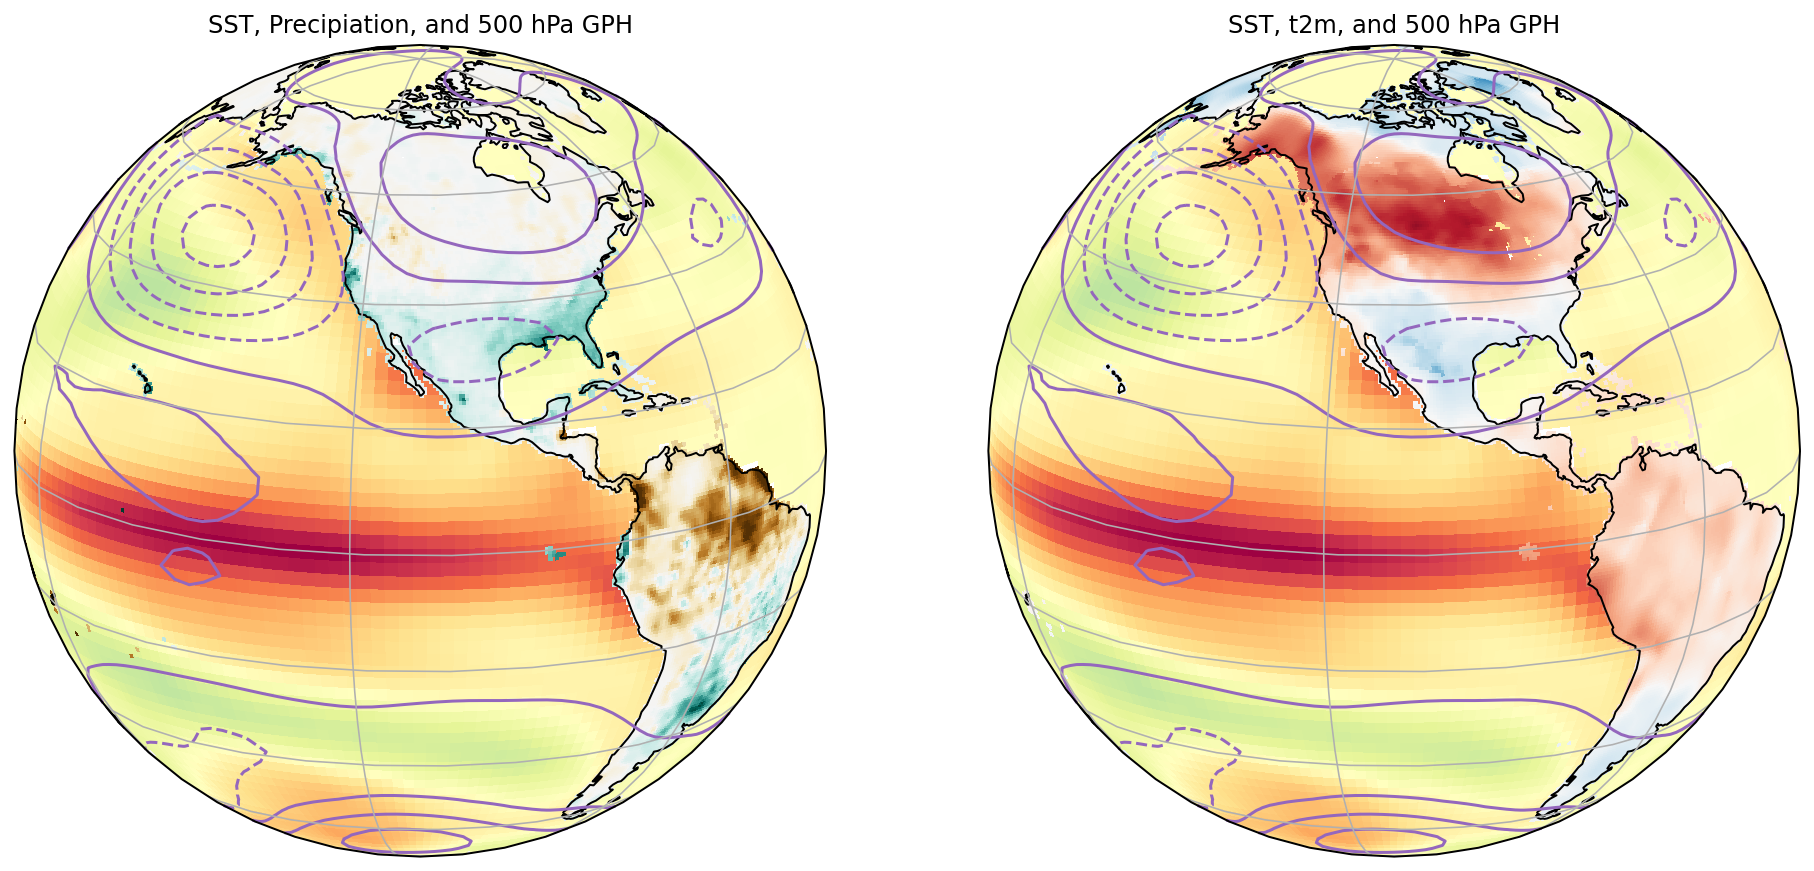

In [19]:
proj_map = ccrs.Orthographic(central_longitude=250.0, central_latitude=15.0)
proj_dta = ccrs.PlateCarree()

fig = plt.figure(figsize=(16, 8))

ax = plt.subplot(121, projection=proj_map)

sst_map.plot(ax = ax, transform = proj_dta, cmap = 'Spectral_r', add_colorbar=False)
prcp_map.plot(ax = ax, transform = proj_dta, vmin = -1.5, cmap = 'BrBG', add_colorbar=False)
phi_map.plot.contour(ax = ax, transform = proj_dta, colors = colors[4], levels = 10)
ax.coastlines()
ax.gridlines()
ax.set_global();
ax.set_title('SST, Precipiation, and 500 hPa GPH');

ax = plt.subplot(122, projection=proj_map)

sst_map.plot(ax = ax, transform = proj_dta, cmap = 'Spectral_r', add_colorbar=False)
t2m_map.plot(ax = ax, transform = proj_dta, vmin = -1.25, cmap = 'RdBu_r', add_colorbar=False)
phi_map.plot.contour(ax = ax, transform = proj_dta, colors = colors[4], levels = 10)
ax.coastlines()
ax.gridlines()
ax.set_global();
ax.set_title('SST, t2m, and 500 hPa GPH');

## 6. Save netcdf

In [20]:
sst_map

<xarray.DataArray 'sst' (Y: 89, X: 180)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-6.5222448e-05, -3.7297334e-05,  0.0000000e+00, ...,
         0.0000000e+00, -2.5292371e-05, -5.8697711e-05],
       [-7.6231867e-05, -6.3112813e-05, -2.5093948e-05, ...,
        -2.9649926e-05, -5.1756382e-05, -7.5014708e-05]], dtype=float32)
Coordinates:
  * X        (X) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * Y        (Y) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0

In [21]:
sst_map.to_netcdf('sst_map.nc', format = 'NETCDF4')
t2m_map.to_netcdf('t2m_map.nc', format = 'NETCDF4')
prcp_map.to_netcdf('prcp_map.nc', format = 'NETCDF4')
phi_map.to_netcdf('phi_map.nc', format = 'NETCDF4')